In [1]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import scipy.sparse

2023-11-19 15:56:49.644361: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 15:56:49.694198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 15:56:49.694245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 15:56:49.695025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 15:56:49.701527: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 15:56:49.702033: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
mp_face_mes = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mes.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: 

In [3]:
frame = cv2.imread('angry.jpeg') # read the image *** change the path to your image

In [4]:
def preprocess_frame(frame):
    H, W, _ = frame.shape
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_mesh = face_mesh.process(rgb_image)
    mesh_points=np.array([np.multiply([p.x, p.y], [W, H]).astype(int) for p in results_mesh.multi_face_landmarks[0].landmark])
    nose_tip = mesh_points[4]
    forehead = mesh_points[151]
    scale_factor = np.linalg.norm(forehead - nose_tip)
    if np.isclose(scale_factor, 0):
        scale_factor = 1e-6
    return results_mesh, mesh_points, scale_factor

In [5]:
results_mesh, mesh_points, scale_factor = preprocess_frame(frame)

In [6]:
def gera_grafos(results_mesh, mesh_points, scale_factor):
    graph = nx.Graph()
    vertices = []
    edges = []
    distances = []

    for edge in FACEMESH_TESSELATION:
        pointA_index = edge[0]
        pointB_index = edge[1]
        if [pointA_index, pointB_index] not in edges:
            edges.append([pointA_index, pointB_index])
            graph.add_edge(pointA_index, pointB_index)
            x_diff = results_mesh.multi_face_landmarks[0].landmark[pointA_index].x - results_mesh.multi_face_landmarks[0].landmark[pointB_index].x
            y_diff = results_mesh.multi_face_landmarks[0].landmark[pointA_index].y - results_mesh.multi_face_landmarks[0].landmark[pointB_index].y
            x_diff /= scale_factor
            y_diff /= scale_factor
            x_diff *= 100000
            y_diff *= 100000
            distances.append(math.sqrt(x_diff**2 + y_diff**2))
        if pointA_index not in vertices:
            vertices.append(pointA_index)
            graph.add_node(pointA_index)
        if pointB_index not in vertices:
            vertices.append(pointB_index)
            graph.add_node(pointB_index)
    return graph

In [7]:
def plot_graph(graph, mesh_points):
    plt.figure(figsize=(10,10))
    nx.draw_networkx(graph, pos=mesh_points, node_size=10, node_color='black', edge_color='black', with_labels=False)
    plt.show()

In [8]:
def get_matrix_adj(graph):
    matrix_adj = nx.adjacency_matrix(graph)
    sparce_matrix = scipy.sparse.csr_matrix(matrix_adj)
    return sparce_matrix    

In [9]:
def save_adjacency_matrix(adjacency_matrix, filename):
    scipy.sparse.save_npz(f'{filename}.npz', adjacency_matrix)

In [11]:
def pipeline(img, plot=False):
    name = img.split('.')[0]
    frame = cv2.imread(img)  # read the image *** change the path to your image
    results_mesh, mesh_points, scale_factor = preprocess_frame(frame)
    graph = gera_grafos(results_mesh, mesh_points, scale_factor)
    adjacency_matrix = get_matrix_adj(graph)

    save_adjacency_matrix(adjacency_matrix, name)
    if plot:
        plot_graph(graph, mesh_points)

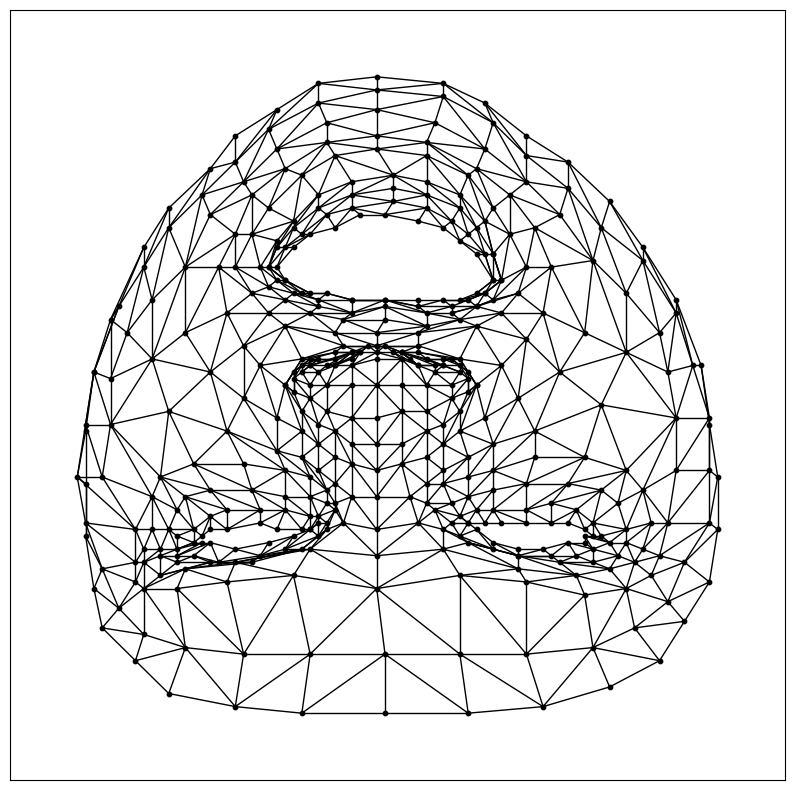

In [12]:
pipeline("angry.jpeg", plot=True)

## Aplicando a pipeline para o dataset de treino

In [ ]:
### começando pelas fotos do tipo angry

import pathlib

actual_path = pathlib.Path().absolute()

# subindo um nível

path = actual_path.parent

angry_path = path / 'face_angry'

# constando o número de arquivos jpg

import os

angry_files = os.listdir(angry_path)

print(len(angry_files))